<a href="https://colab.research.google.com/github/nomomon/drl-js/blob/main/tic-tac-toe/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

import random

# Game (Environment)

In [3]:
# 0 1 2
# 3 4 5
# 6 7 8

def gameStatus(board):
    lines = [
        [0, 1, 2],
        [3, 4, 5],
        [6, 7, 8],
        [0, 3, 6],
        [1, 4, 7],
        [2, 5, 8],
        [0, 4, 8],
        [2, 4, 6],
    ]

    # there is a winner
    for line in lines:
        if (board[line[1]] == board[line[0]] and 
            board[line[1]] == board[line[2]] and 
            board[line[1]] != 0):
            return board[line[1]]

    # tie
    if(np.all(np.array(board) != 0)):
        return 0.5

    # game is not finished
    return 0

# Model

In [5]:
### Agent ###

def createPolicy():
    model = tf.keras.Sequential([
        layers.InputLayer((9,)),
        layers.Dense(10, activation = "relu"),
        layers.Dense(10, activation = "relu"),
        layers.Dense(9, activation = None)
    ])

    return model

In [9]:
policy = createPolicy()
policy.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                100       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 9)                 99        
                                                                 
Total params: 309
Trainable params: 309
Non-trainable params: 0
_________________________________________________________________


In [6]:
def chooseAction(policy, board, epsilon = 0):
    mask = [-np.inf if v != 0 else 0 for v in board]

    if np.random.rand(1) > epsilon:
        logits = policy.predict([board])

        possibleLogits = tf.math.add(
            logits, 
            mask
        )

    else:
        possibleLogits = [mask] + np.log(1/9)
     
    action = tf.random.categorical(possibleLogits, num_samples = 1)
    action = action.numpy().flatten()[0]

    return action

In [7]:
### Agent Memory ###

class Memory:
    def __init__(self): 
        self.clear()

    def clear(self): 
        self.observations = []
        self.actions = []
        self.rewards = []

    def add_to_memory(self, new_observation, new_action, new_reward): 
        self.observations.append(new_observation)
        self.actions.append(new_action)
        self.rewards.append(new_reward)

    # Helper function to combine a list of Memory objects into a single Memory.
    # This will be very useful for batching.
    def aggregate_memories(memories):
        batch_memory = Memory()

        for memory in memories:
            for step in zip(memory.observations, memory.actions, memory.rewards):
                batch_memory.add_to_memory(*step)

        return batch_memory

In [8]:
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma = 0.95): 
    discounted_rewards = np.zeros_like(rewards)
    
    R = 0
    for t in reversed(range(0, len(rewards))):
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
        
    return normalize(discounted_rewards)

In [10]:
def compute_loss(logits, actions, rewards):
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, 
        labels=actions
    )
    # reinforce
    loss = tf.reduce_mean(
        neg_logprob * rewards
    )
    
    return loss

In [11]:
### Training step (forward and backpropagation) ###

def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
      logits = model(observations)
      loss = compute_loss(logits, actions, discounted_rewards)

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss


# Plot

In [12]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [13]:
def plot(points, ylabel = ""):
    plt.rcParams["figure.figsize"] = (7, 4)
    plt.clf()
    plt.plot(points)
    plt.ylabel(ylabel)
    plt.xlabel("episode")
    plt.show()

def smooth(points, alpha = 0.05):
    smoothed = [points[0]]

    for i in range(1, len(points)):
        smoothed.append(points[i] * alpha + smoothed[i - 1] * (1 - alpha))

    return smoothed

# Training

In [14]:
winper_points = []
reward_points = []
hist_points = []

episode = 0
policy = createPolicy()

memory_first = Memory()
memory_second = Memory()

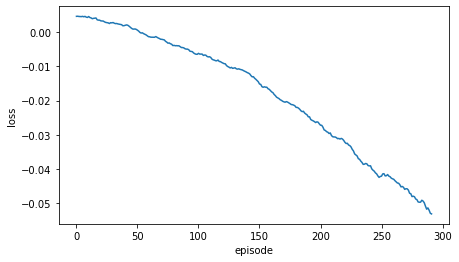

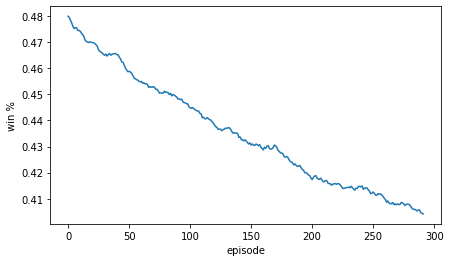

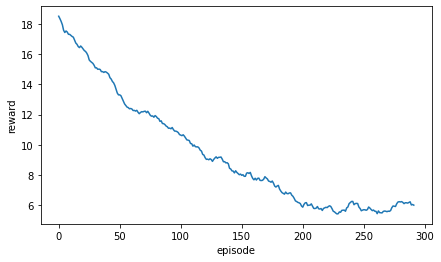

291 loss: -0.07181079685688019
291 winPer: 0.38
291 reward: 1.5


KeyboardInterrupt: ignored

In [15]:
episodes = 1000
games_per_episode = 100

learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

opponent_policy = tf.keras.models.clone_model(policy)

for episode in range(episode, episodes):
    board = [0] * 9
    memory_first.clear()
    memory_second.clear()
    first_time = 1
    counter = 0
    win = 0

    eps = 0.99 ** (episode / 2)

    while True:
        if(player_goes_first and gameStatus(board) == 0):
            action = chooseAction(policy, board, eps)

        elif((not player_goes_first) and gameStatus(board) == 0):
            if(first_time):
                first_time -= 1
                opponent_action = chooseAction(policy, (np.array(board) * -1).tolist(), eps)
                board[opponent_action] = -1
            action = chooseAction(policy, board, eps)

        next_board = board
        next_board[action] = 1

        status = gameStatus(next_board)

        if(status == 0): # game goes on
            opponent_action = chooseAction(policy, (np.array(next_board) * -1).tolist())
            next_board[opponent_action] = -1

            status = gameStatus(next_board)
    
        reward = status

        memory.add_to_memory(board, action, reward)

        if(status != 0):
            win += (status == 1)
            counter += 1
            next_board = [0] * 9
            first_time = 1
            player_goes_first = bool(random.getrandbits(1))
        
        if(status != 0 and counter >= games_per_episode):
            loss = train_step(
                policy, 
                optimizer, 
                observations = np.vstack(memory.observations),
                actions = np.array(memory.actions),
                discounted_rewards = discount_rewards(memory.rewards)
            )

            total_reward = sum(memory.rewards)
            
            winper_points.append(win / counter)
            reward_points.append(total_reward)
            hist_points.append(loss)

            clear_output()
            plot(smooth(hist_points, 0.01), "loss")
            plot(smooth(winper_points, 0.01), "win %")
            plot(smooth(reward_points, 0.01), "reward")

            print(f"{episode} loss: {loss}")
            print(f"{episode} win %: {win / counter}")
            print(f"{episode} reward: {total_reward}")

            memory.clear()
            board = [0] * 9
            counter = 0
            first_time = 1

            break
    
        board = next_board

# Web demo

Play against the AI

In [ ]:
from IPython.display import clear_output 

def symbol(x):
    if x == 1:
        return "X"
    elif x == -1:
        return "O"
    else:
        return "?"

def printBoard(board):
    clear_output()
    cBoard = list(map(symbol, board))
    for i in range(0, 3):
        row = ""
        for j in range(0, 3):
            row += (cBoard[j + i * 3]) if (cBoard[j + i * 3] != "?") else str(j + i * 3 + 1)
            if j != 2:
                row += " | "
        print(row)
        if i != 2:
            print("---------")

def play(policy):
    player = (int(input("which player you want to be? (1 or 2) ")) + 1) % 2 

    board = [0, 0, 0,
             0, 0, 0,
             0, 0, 0]

    winner = 0

    for i in range(9):
        if (i % 2 == player):
            printBoard(board)
            action = int(input("what cell? ")) - 1
        else:
            action = chooseAction(policy, board.copy())

        board[action] = 1

        if(gameStatus(board) != 0):
            winner = gameStatus(board)+1
            break

        board = (np.array(board) * -1).tolist()
    
    printBoard(board)
    if(gameStatus(board) != 0):
        print("\nwinner is the", "humen" if winner else "ai")
    else:
        print("\nit's a tie!")

In [ ]:
play(policy)

X | X | O
---------
O | X | 6
---------
O | X | O

winner is the humen


# Deploy to TF.js

In [16]:
%%capture

!pip install tensorflowjs[wizard]
!pip install -U ipython

In [17]:
policy.save("./model/")

INFO:tensorflow:Assets written to: ./model/assets


In [18]:
!tensorflowjs_converter --input_format=keras_saved_model /content/model /content/tfjs_model

2021-11-26 13:28:26.764816: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
